# 📸 Face Recognition - Model Inference & Evaluation

Program ini melakukan:
1. **Load Model** - ConvNeXt-Tiny yang sudah di-train
2. **Load Test Dataset** - Folder `Test/` dengan subfolder sebagai class
3. **Inference** - Prediksi semua gambar test
4. **Evaluasi** - Precision, Recall, F1-Score, Confusion Matrix
5. **Export** - Hasil prediksi ke `jawaban.csv`

## 1. Import Libraries

In [18]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score,
    classification_report,
    confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

# Import model
from model_convnext import create_model

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True


## 2. Configuration

In [19]:
# ============ CONFIGURATION ============
CHECKPOINT_PATH = "checkpoints/convnext_tiny_20251201_144518/best_epoch7.pth"
TEST_DIR = "Test"
CLASS_NAMES_PATH = "class_names.txt"
OUTPUT_CSV = "jawaban.csv"

IMAGE_SIZE = 224
NUM_CLASSES = 70
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"📁 Checkpoint: {CHECKPOINT_PATH}")
print(f"📁 Test Directory: {TEST_DIR}")
print(f"📁 Output CSV: {OUTPUT_CSV}")
print(f"🖥️ Device: {DEVICE}")

📁 Checkpoint: checkpoints/convnext_tiny_20251201_144518/best_epoch7.pth
📁 Test Directory: Test
📁 Output CSV: jawaban.csv
🖥️ Device: cuda


## 3. Load Class Names

In [20]:
# Load class names dari file
with open(CLASS_NAMES_PATH, "r", encoding="utf-8") as f:
    class_names = [line.strip() for line in f if line.strip()]

print(f"✅ Loaded {len(class_names)} class names")
print(f"\n📋 Sample class names:")
for i, name in enumerate(class_names[:5]):
    print(f"   {i}: {name}")
print(f"   ...")
print(f"   {len(class_names)-1}: {class_names[-1]}")

✅ Loaded 70 class names

📋 Sample class names:
   0: Abraham Ganda Napitu
   1: Abu Bakar Siddiq Siregar
   2: Ahmad Faqih Hasani
   3: Aldi Sanjaya
   4: Alfajar
   ...
   69: hayyatul fajri


## 4. Load Trained Model

In [21]:
# Create model (tanpa pretrained weights, kita akan load dari checkpoint)
model = create_model(num_classes=NUM_CLASSES, pretrained=False, dropout=0.3, device=DEVICE)

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

# Extract state dict
if isinstance(checkpoint, dict):
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    elif "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint
else:
    state_dict = checkpoint

# Load weights
model.load_state_dict(state_dict, strict=True)
model.eval()

print(f"✅ Model loaded from: {CHECKPOINT_PATH}")
print(f"📊 Total parameters: {model.get_num_total_params():,}")
print(f"🎯 Number of classes: {NUM_CLASSES}")

✅ Model loaded from: checkpoints/convnext_tiny_20251201_144518/best_epoch7.pth
📊 Total parameters: 27,873,958
🎯 Number of classes: 70


## 5. Load Test Dataset

In [22]:
# Transform untuk inference (sama dengan validation)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Collect all test images
test_data = []
test_dir = Path(TEST_DIR)
valid_extensions = {'.jpg', '.jpeg', '.png', '.webp', '.bmp'}

for class_folder in sorted(test_dir.iterdir()):
    if class_folder.is_dir():
        class_name = class_folder.name
        for img_path in class_folder.iterdir():
            if img_path.suffix.lower() in valid_extensions:
                test_data.append({
                    'path': str(img_path),
                    'filename': img_path.name,
                    'true_label': class_name
                })

print(f"✅ Found {len(test_data)} test images")
print(f"📁 From {len(list(test_dir.iterdir()))} class folders")

# Show sample
print(f"\n📋 Sample test data:")
for i, data in enumerate(test_data[:3]):
    print(f"   {i+1}. {data['filename']} -> {data['true_label']}")

✅ Found 70 test images
📁 From 70 class folders

📋 Sample test data:
   1. IMG_2138 - Abraham Ganda Napitu.jpeg -> Abraham Ganda Napitu
   2. 1 - I22I4OI64_ ABU BAKAR SIDDIQ SIREGAR.jpeg -> Abu Bakar Siddiq Siregar
   3. Ahmad Faqih Hasani_1.jpg -> Ahmad Faqih Hasani


## 6. Run Inference

In [23]:
# Run inference on all test images
results = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_data, desc="🔄 Running inference"):
        try:
            # Load and preprocess image
            img = Image.open(data['path']).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(DEVICE)
            
            # Inference
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1)[0]
            
            # Get prediction
            confidence, pred_idx = torch.max(probs, dim=0)
            pred_label = class_names[pred_idx.item()]
            
            # Get top 5
            top5_probs, top5_idx = torch.topk(probs, 5)
            top5_labels = [class_names[i.item()] for i in top5_idx]
            
            results.append({
                'filename': data['filename'],
                'true_label': data['true_label'],
                'pred_label': pred_label,
                'confidence': confidence.item(),
                'correct': data['true_label'] == pred_label,
                'top5_labels': top5_labels,
                'top5_probs': top5_probs.cpu().numpy()
            })
            
        except Exception as e:
            print(f"❌ Error processing {data['filename']}: {e}")
            results.append({
                'filename': data['filename'],
                'true_label': data['true_label'],
                'pred_label': 'ERROR',
                'confidence': 0.0,
                'correct': False,
                'top5_labels': [],
                'top5_probs': []
            })

print(f"\n✅ Inference completed for {len(results)} images")

🔄 Running inference: 100%|██████████| 70/70 [00:07<00:00,  9.40it/s]


✅ Inference completed for 70 images


## 7. Evaluation Metrics

In [24]:
# Extract labels for metrics calculation
y_true = [r['true_label'] for r in results]
y_pred = [r['pred_label'] for r in results]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Top-5 accuracy
top5_correct = sum(1 for r in results if r['true_label'] in r['top5_labels'])
top5_accuracy = top5_correct / len(results)

print("=" * 60)
print("📊 EVALUATION METRICS")
print("=" * 60)
print(f"\n🎯 Accuracy (Top-1): {accuracy * 100:.2f}%")
print(f"🎯 Accuracy (Top-5): {top5_accuracy * 100:.2f}%")
print(f"\n📈 Macro Average:")
print(f"   • Precision: {precision_macro * 100:.2f}%")
print(f"   • Recall:    {recall_macro * 100:.2f}%")
print(f"   • F1-Score:  {f1_macro * 100:.2f}%")
print(f"\n📈 Weighted Average:")
print(f"   • Precision: {precision_weighted * 100:.2f}%")
print(f"   • Recall:    {recall_weighted * 100:.2f}%")
print(f"   • F1-Score:  {f1_weighted * 100:.2f}%")
print("=" * 60)

📊 EVALUATION METRICS

🎯 Accuracy (Top-1): 44.29%
🎯 Accuracy (Top-5): 71.43%

📈 Macro Average:
   • Precision: 37.74%
   • Recall:    44.29%
   • F1-Score:  39.31%

📈 Weighted Average:
   • Precision: 37.74%
   • Recall:    44.29%
   • F1-Score:  39.31%


## 8. Classification Report (Per-Class Metrics)

In [25]:
# Get unique labels that appear in predictions or ground truth
unique_labels = sorted(set(y_true + y_pred))

# Classification report
print("📋 CLASSIFICATION REPORT (Per-Class)")
print("=" * 80)
report = classification_report(y_true, y_pred, labels=unique_labels, zero_division=0)
print(report)

📋 CLASSIFICATION REPORT (Per-Class)
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       0.00      0.00      0.00         1
       Abu Bakar Siddiq Siregar       0.00      0.00      0.00         1
             Ahmad Faqih Hasani       0.00      0.00      0.00         1
                   Aldi Sanjaya       0.00      0.00      0.00         1
                        Alfajar       0.00      0.00      0.00         1
            Alief Fathur Rahman       0.00      0.00      0.00         1
 Arkan Hariz Chandrawinata Liem       0.00      0.00      0.00         1
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       0.33      1.00      0.50         1
           Bezalel Samuel Manik       0.00      0.00      0.00         1
           Bintang Fikri Fauzan       0.00      0.00      0.00         1
              Boy Sandro Sigiro       0.00      0.00      0.00         1
             D

## 9. Confusion Matrix

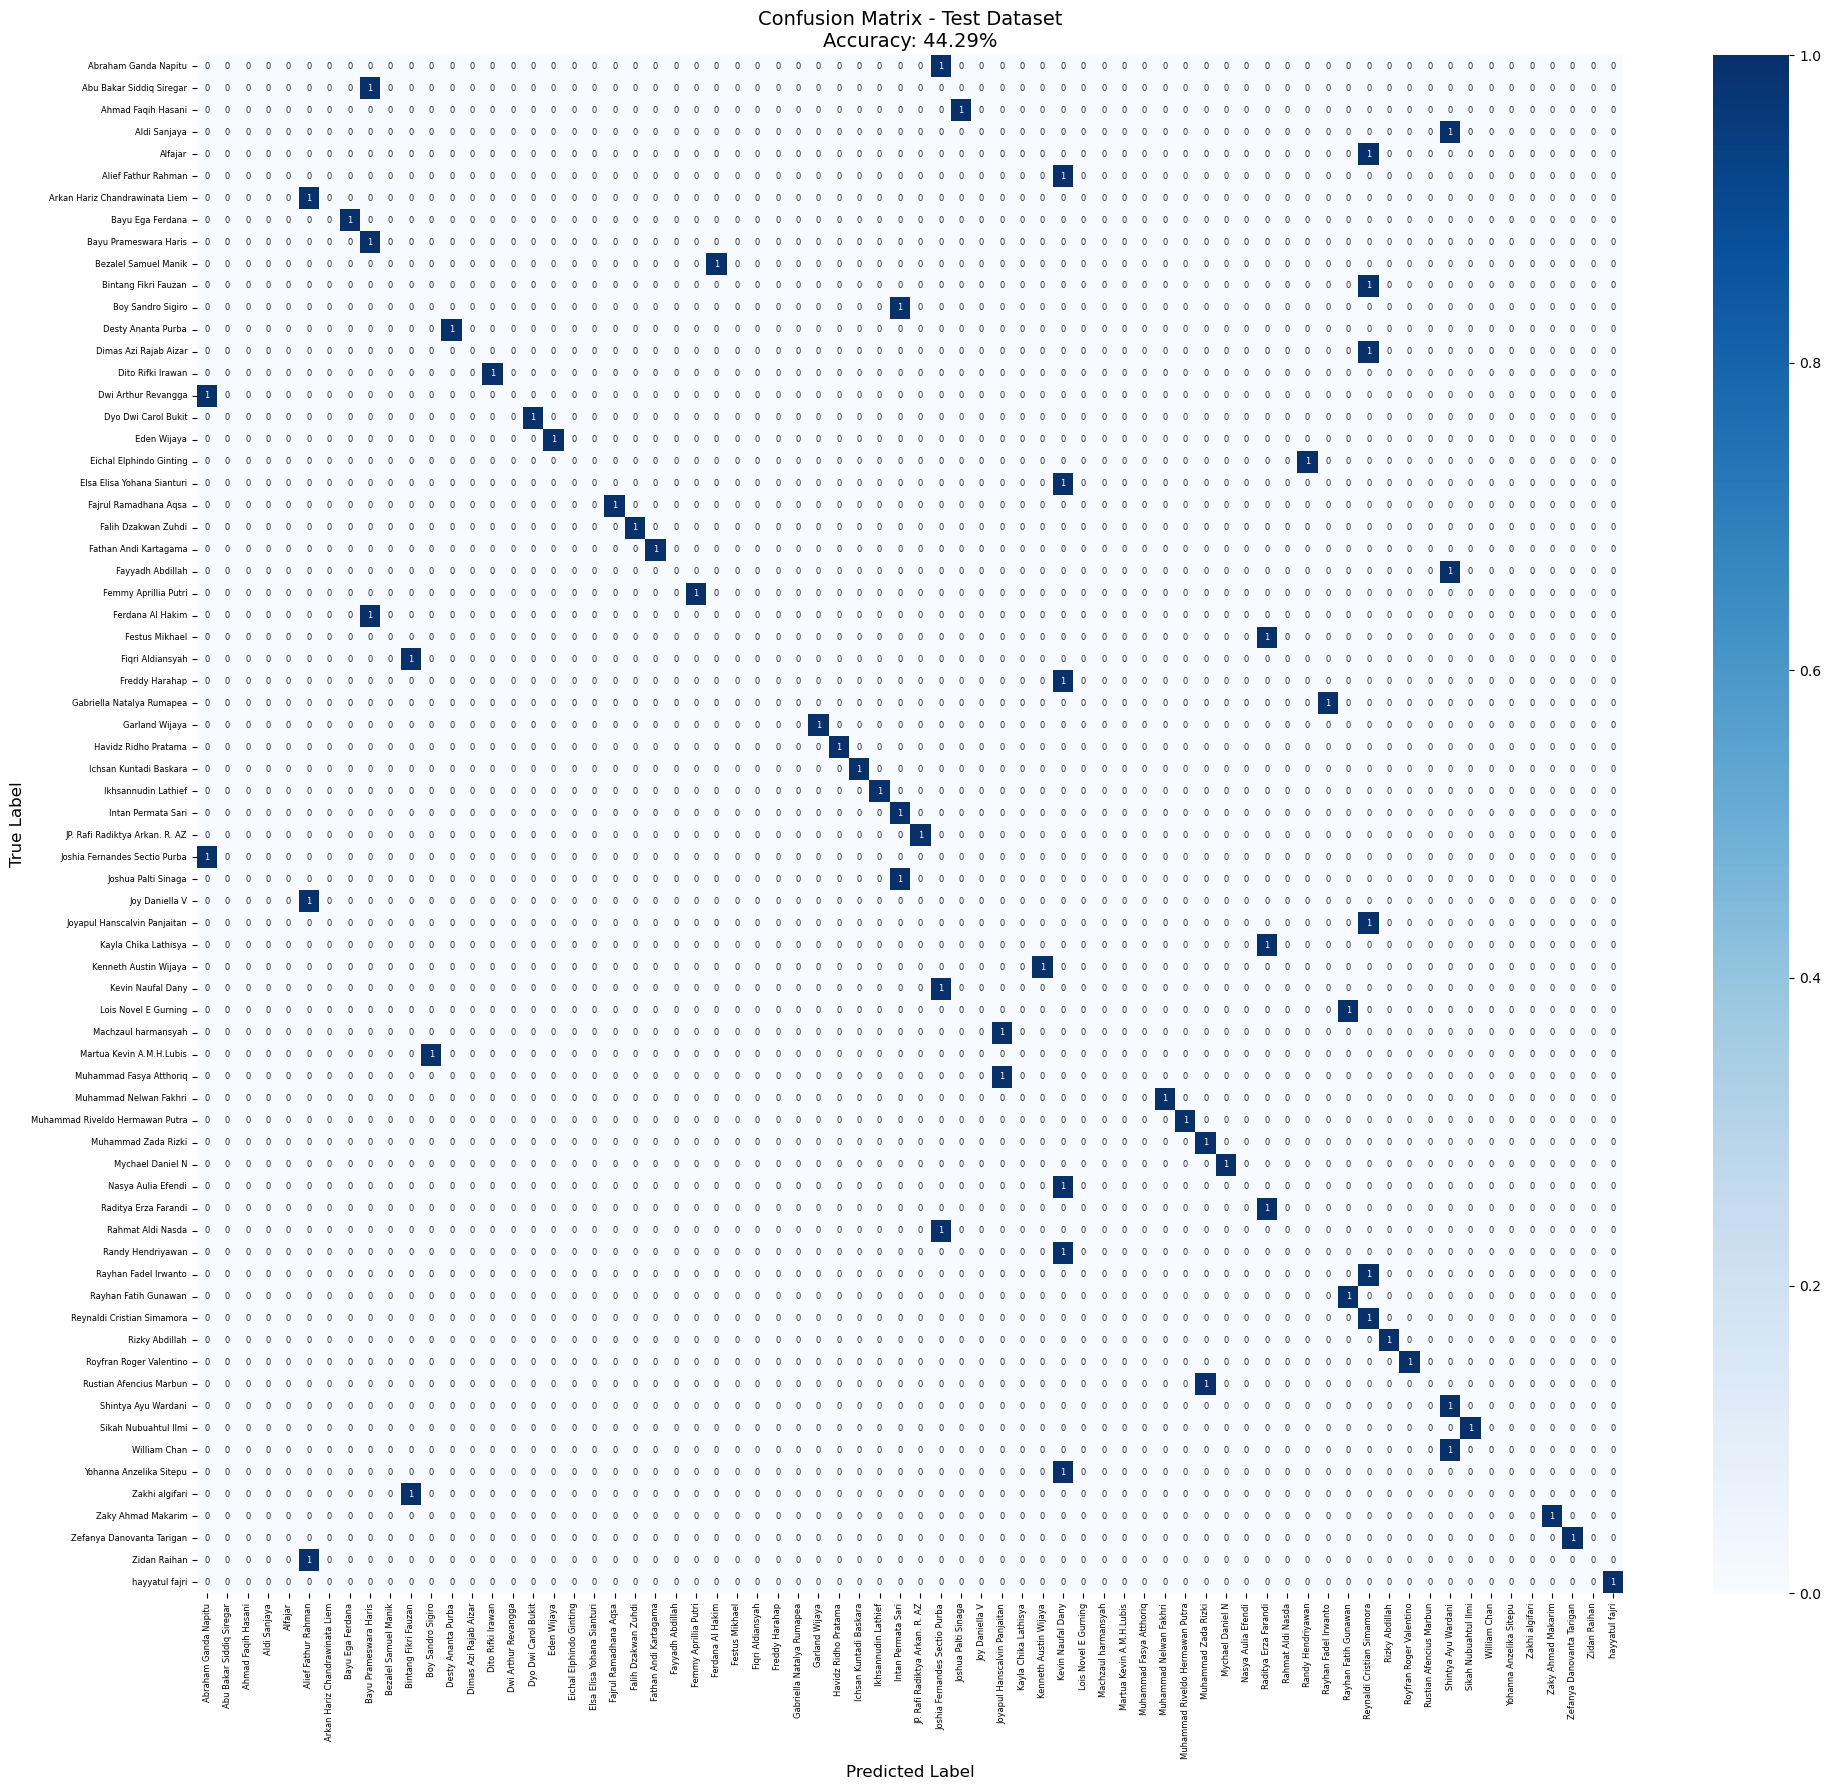


✅ Confusion matrix saved to: confusion_matrix_test.png


In [26]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    annot_kws={'size': 6}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - Test Dataset\nAccuracy: {accuracy*100:.2f}%', fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig('confusion_matrix_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Confusion matrix saved to: confusion_matrix_test.png")

## 10. Export Results to CSV (jawaban.csv)

In [27]:
# Create DataFrame for export
df_results = pd.DataFrame([{
    'filename': r['filename'],
    # 'true_label': r['true_label'],
    'label': r['pred_label'],
    # 'confidence': f"{r['confidence']*100:.2f}%",
    # 'correct': '✓' if r['correct'] else '✗'
} for r in results])

# Save to CSV
df_results.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')

print(f"✅ Results saved to: {OUTPUT_CSV}")
print(f"📊 Total predictions: {len(df_results)}")
print(f"✓ Correct: {sum(r['correct'] for r in results)}")
print(f"✗ Incorrect: {sum(not r['correct'] for r in results)}")

# Display sample
print(f"\n📋 Sample results:")
df_results.head(10)

✅ Results saved to: jawaban.csv
📊 Total predictions: 70
✓ Correct: 31
✗ Incorrect: 39

📋 Sample results:


,filename,label
0,IMG_2138 - Abraham Ganda Napitu.jpeg,Joshia Fernandes Sectio Purba
1,1 - I22I4OI64_ ABU BAKAR SIDDIQ SIREGAR.jpeg,Bayu Prameswara Haris
2,Ahmad Faqih Hasani_1.jpg,Joshua Palti Sinaga
3,IMG_2042 - ALDI SANJAYA.jpeg,Shintya Ayu Wardani
4,IMG_20250704_132032 - I22I40I22 - ALFAJAR.jpg,Reynaldi Cristian Simamora
5,2025-10-21 06.59.30 1 - Alief Fathur Rahman.jpg,Kevin Naufal Dany
6,Arkan_1 - ARKAN HARIZ CHANDRAWINATA LIEM.jpg,Alief Fathur Rahman
7,IMG-20251124-WA0018 - Bayu Ega Ferdana.jpg,Bayu Ega Ferdana
8,BayuPrameswaraHaris_1 - Bayu Prameswara Haris....,Bayu Prameswara Haris
9,Bez1 - Bezalel Manik.jpeg,Ferdana Al Hakim


## 11. Summary

In [28]:
# Final Summary
print("=" * 60)
print("📊 FINAL SUMMARY")
print("=" * 60)
print(f"""
🏷️  Model: ConvNeXt-Tiny
📁 Checkpoint: {CHECKPOINT_PATH}
📁 Test Dataset: {TEST_DIR}/
📊 Total Test Images: {len(results)}
📋 Output CSV: {OUTPUT_CSV}

📈 PERFORMANCE METRICS:
┌─────────────────────┬───────────────┐
│ Metric              │ Value         │
├─────────────────────┼───────────────┤
│ Accuracy (Top-1)    │ {accuracy*100:>10.2f}%  │
│ Accuracy (Top-5)    │ {top5_accuracy*100:>10.2f}%  │
│ Precision (Macro)   │ {precision_macro*100:>10.2f}%  │
│ Recall (Macro)      │ {recall_macro*100:>10.2f}%  │
│ F1-Score (Macro)    │ {f1_macro*100:>10.2f}%  │
│ Precision (Weighted)│ {precision_weighted*100:>10.2f}%  │
│ Recall (Weighted)   │ {recall_weighted*100:>10.2f}%  │
│ F1-Score (Weighted) │ {f1_weighted*100:>10.2f}%  │
└─────────────────────┴───────────────┘

✅ Inference completed successfully!
""")
print("=" * 60)

📊 FINAL SUMMARY

🏷️  Model: ConvNeXt-Tiny
📁 Checkpoint: checkpoints/convnext_tiny_20251201_144518/best_epoch7.pth
📁 Test Dataset: Test/
📊 Total Test Images: 70
📋 Output CSV: jawaban.csv

📈 PERFORMANCE METRICS:
┌─────────────────────┬───────────────┐
│ Metric              │ Value         │
├─────────────────────┼───────────────┤
│ Accuracy (Top-1)    │      44.29%  │
│ Accuracy (Top-5)    │      71.43%  │
│ Precision (Macro)   │      37.74%  │
│ Recall (Macro)      │      44.29%  │
│ F1-Score (Macro)    │      39.31%  │
│ Precision (Weighted)│      37.74%  │
│ Recall (Weighted)   │      44.29%  │
│ F1-Score (Weighted) │      39.31%  │
└─────────────────────┴───────────────┘

✅ Inference completed successfully!

